<a href="https://colab.research.google.com/github/Nikhilkps1904/Iris-Segmenation/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# prompt: connect with drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


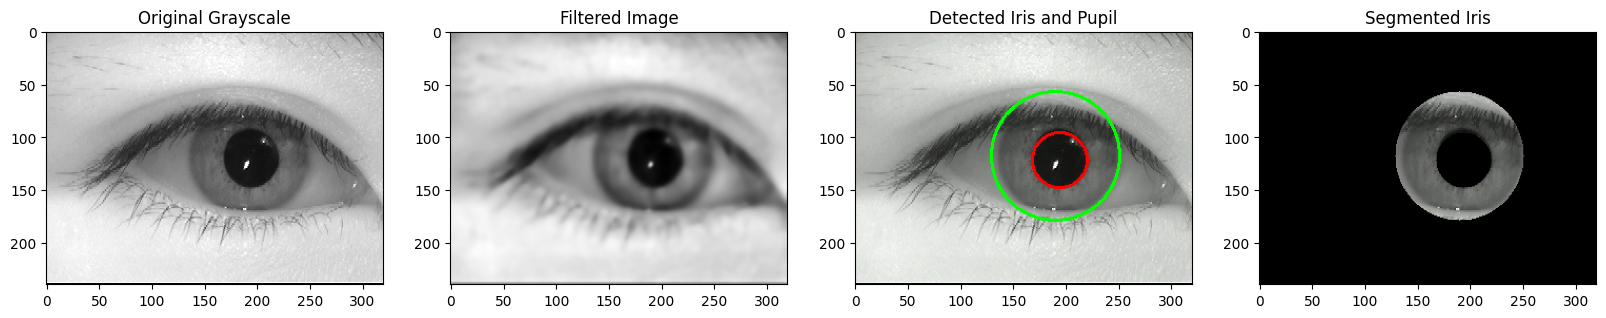

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def load_image(file_path):
    img = cv2.imread(file_path, -1)
    if img is None:
        raise ValueError("Error: Could not read the image file.")
    if img.dtype != np.uint8:
        img = (img / 256).astype('uint8')
    return img

def advanced_preprocess(img):
    if len(img.shape) == 3:
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        img_gray = img

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img_clahe = clahe.apply(img_gray)

    img_bilateral = cv2.bilateralFilter(img_clahe, 9, 75, 75)
    img_median = cv2.medianBlur(img_bilateral, 5)
    img_gaussian = cv2.GaussianBlur(img_median, (5, 5), 0)

    return img_gray, img_gaussian

def detect_iris_and_pupil(img_filtered):
    height, width = img_filtered.shape
    min_radius = min(height, width) // 10
    max_radius = min(height, width) // 2

    for param2 in range(30, 10, -1):  # Try different param2 values
        iris_circles = cv2.HoughCircles(
            img_filtered, cv2.HOUGH_GRADIENT, dp=1, minDist=width//2,
            param1=50, param2=param2, minRadius=min_radius, maxRadius=max_radius
        )

        if iris_circles is not None:
            iris_circles = np.uint16(np.around(iris_circles))[0, :]
            iris_circle = max(iris_circles, key=lambda x: x[2])  # Select the largest circle

            # Create a mask for the iris region
            mask = np.zeros(img_filtered.shape, dtype=np.uint8)
            cv2.circle(mask, (iris_circle[0], iris_circle[1]), iris_circle[2], 255, -1)

            # Apply the mask to the image
            iris_region = cv2.bitwise_and(img_filtered, mask)

            # Detect pupil within the iris region
            pupil_circles = cv2.HoughCircles(
                iris_region, cv2.HOUGH_GRADIENT, dp=1, minDist=width//4,
                param1=50, param2=30, minRadius=min_radius//2, maxRadius=iris_circle[2]//2
            )

            if pupil_circles is not None:
                pupil_circles = np.uint16(np.around(pupil_circles))[0, :]
                pupil_circle = min(pupil_circles, key=lambda x: x[2])  # Select the smallest circle
                return iris_circle, pupil_circle, img_filtered

    return None, None, img_filtered

def segment_iris(img, iris_circle, pupil_circle):
    if iris_circle is not None and pupil_circle is not None:
        mask = np.zeros(img.shape[:2], dtype=np.uint8)
        cv2.circle(mask, (iris_circle[0], iris_circle[1]), iris_circle[2], 255, -1)
        cv2.circle(mask, (pupil_circle[0], pupil_circle[1]), pupil_circle[2], 0, -1)
        segmented_iris = cv2.bitwise_and(img, img, mask=mask)
        return segmented_iris
    return None

def draw_circles(img, iris_circle, pupil_circle):
    result = img.copy()
    if iris_circle is not None:
        cv2.circle(result, (iris_circle[0], iris_circle[1]), iris_circle[2], (0, 255, 0), 2)
    if pupil_circle is not None:
        cv2.circle(result, (pupil_circle[0], pupil_circle[1]), pupil_circle[2], (0, 0, 255), 2)
    return result

def main():
    try:
        img = load_image(r'/content/drive/MyDrive/CG project/DemoData/christiner2.bmp')
        img_gray, img_filtered = advanced_preprocess(img)

        iris_circle, pupil_circle, debug_img = detect_iris_and_pupil(img_filtered)

        if iris_circle is None or pupil_circle is None:
            print("Error: Could not detect iris or pupil.")
            # Display diagnostic information
            plt.figure(figsize=(15, 5))
            plt.subplot(131), plt.imshow(img_gray, cmap='gray'), plt.title('Original Grayscale')
            plt.subplot(132), plt.imshow(img_filtered, cmap='gray'), plt.title('Filtered Image')
            plt.subplot(133), plt.imshow(debug_img, cmap='gray'), plt.title('Debug Image')
            plt.show()
            return

        segmented_iris = segment_iris(img, iris_circle, pupil_circle)
        result_img = draw_circles(img, iris_circle, pupil_circle)

        plt.figure(figsize=(20, 5))
        plt.subplot(141), plt.imshow(img_gray, cmap='gray'), plt.title('Original Grayscale')
        plt.subplot(142), plt.imshow(img_filtered, cmap='gray'), plt.title('Filtered Image')
        plt.subplot(143), plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)), plt.title('Detected Iris and Pupil')
        plt.subplot(144), plt.imshow(cv2.cvtColor(segmented_iris, cv2.COLOR_BGR2RGB)), plt.title('Segmented Iris')
        plt.show()

    except Exception as e:
        print(f"An error occurred: {str(e)}")

if __name__ == "__main__":
    main()